# Neural Networks Final Project
### Reimplementation of the study: <br> ***"DE-FAKE: Detection and Attribution of Fake Images Generated by Text-to-Image GenerationModels"* <br> from Zeyang Sha, Zheng Li, Ning Yu, Yang Zhang**

**Name**: *Laura Papi*

**Matricola**: *1760732*


# Project Description

The above cited study focuses on the growing concerns about the possible misuse of AI generated images, and assesses the necessity for a tool to detect and attribute these fake images.<br>
In particular, it points out the lack of research on the particular case of images generated by a text prompt.
<br>

<br>
This project proposes methods to answer 2 of the research questions [RQ] proposed in the paper:

- **RQ1**. Detection of images generated by text-to-image generation models (See sections 1 and 2)

- **RQ2**. Attribution of the fake images to the text-to-image model that generated it (See sections 3 and 4)

<br>
This notebook contains the instructions to test the models that were implemented to answer these questions.<br>
In the following sections there are instructions to download the pre-built datasets and the pre-trained weights for the models, in order to test the performance results of this work.<br><br>


For a more detailed description of the work done see the __[Complete Notebook](complete_notebook.ipynb)__.<br>
The complete notebook can be used to reproduce the entire project from scratch, from the creation of the datasets to the design and training of the models.

For furhter informations the complete code of this project can be found in the source directory of the public GitHub repository __[Source Code](https://github.com/parwal-lp/De-Fake_nn_final_project/tree/main/src)__

Before proceeding to run the code in this Notebook, please read the instructions contained in the __[Readme](https://github.com/parwal-lp/De-Fake_nn_final_project/tree/main)__ on GitHub.

## Download the Datasets
First of all it is necessary to download the pre-built and labeled datasets on which the models can be evaluated.<br><br>
Get the compressed folder containing all the datasets from this download link: __[Datasets](https://drive.google.com/drive/folders/1Z2qrihz_gKY7R6dula-f0eKjjGxBba6u?usp=sharing)__.<br>
Then extract the "data" folder and place it at the root of this git repository.

## Download the pre-traned Weights
Then it is also necessary to retrieve the trained weights for all the models to be evaluated.<br><br>
They can be downloaded using the following link: __[Trained weights](https://drive.google.com/drive/u/1/folders/1xJvd_5bHe_Sl70gp0BIStJvDXm_947hi)__.<br>
Then extract the "trained_models" folder and place it at the root of this git reporitory.

## Run the Models

For each RQ, the study proposes two possible models to answer the question:

1. **Image-only**<br>classifies the image based solely on the input image. (See sections 1 and 3).

2. **Hybrid**<br>classifies the image based on the image together with the text prompt that describes the image and that was used to generate it. (See sections 2 and 4).

Import all the necessary libraries and functions:

In [1]:
# External libraries
import torch
import torchvision
import os

# Custom functions implemented for this project
# Models functions
from src.imageonly_detector.model import eval_imageonly_detector
from src.imageonly_attributor.model import eval_imageonly_attributor
from src.hybrid_detector.hybrid_detector import TwoLayerPerceptron, eval_hybrid_detector
from src.hybrid_attributor.model import MultiClassTwoLayerPerceptron, eval_hybrid_attributor
# Datasets functions
from src.encoder import get_multiclass_dataset_loader, get_dataset_loader

Define the necessary paths using the following variables as specified below:

In [2]:
# Define custom directories for external models

clip_dir = "/home/parwal/Documents/GitHub/CLIP"     # Replace this path with the absolute path to the root of the CLIP repository
proj_dir = "/home/parwal/Documents/GitHub/De-Fake_nn_final_project"     # Replace this path with the absolute path to the root of this repository

## RQ1 - Detection of fake images

### 1. Image-only Detector

- **Goal:** A classifier that given an image is able to tell if it is real or fake;<br>where fake means that it is generated from a text-to-image generation model.<br>
- **Model Design:** Binary classifier implemented through a two-layer perceptron.<br>
- **Dataset:** The model is tested on 3 different two-class datasets (real images = class 1, fake images = class 0).<br>
    - __class 1__: The **real images** are always fetched from MSCOCO, together with their textual descriptions (captions).<br>
    - __class 0__: The **fake images** are generated by Stable Diffusion (SD) for the first dataset, Latent Diffusion (LD) for the second and GLIDE for the third. The fake images are generated using as text-prompt the captions of the real images.<br>

    To summarize, the obtained dataset has: **N captions**, the **N real original images** corresponding to those captions, and **N fake images** generated using those captions.<br>
    Since the model was trained on images generated by SD, we expect higher accuracy for that case.

In [8]:
# -- First create Dataloaders loading images in batches from the data folder
print("Building the dataset...")
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_dir = 'data/imageonly_detector_data'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in ['val', 'val_LD', 'val_GLIDE']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['val', 'val_LD', 'val_GLIDE']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['val', 'val_LD', 'val_GLIDE']}

# -- Build the model
print("loading model with trained weights...")
# start from a pretrained version of ResNet18 (tranfer learning)
imageonly_detector = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# Load the pre-trained weights generated during training (see complete notebook and source code for details)
imageonly_detector.load_state_dict(torch.load('trained_models/imageonly_detector.pth'))

# -- Then evaluate the model using the dataloaders defined above
print("Evaluation starts")
eval_imageonly_detector(imageonly_detector, dataloaders, dataset_sizes)


Building the dataset...
loading model with trained weights...
Evaluation starts
Evaluation on SD -> Acc: 0.9082 - Loss: 0.2114
Evaluation on LD -> Acc: 0.6600 - Loss: 1.1218
Evaluation on GLIDE -> Acc: 0.7500 - Loss: 0.6662
Evaluation complete in 0m 1s


### 2. Hybrid Detector

- **Goal:** A classifier that given an image **and its textual description** is able to tell if it is real or fake.<br>Fake means that it is generated from a text-to-image generation model, and the textual description is the text-prompt used to generate it.<br><br>
- **Model Design:** Binary classifier implemented through a two-layer perceptron.<br><br>
- **Dataset:** The dataset is built in the same way as in the image-only detector case.<br>
The difference is that in this case the model must take as input not only the image, but also its caption.<br>
In order to obtain this, the data is be processed as follows:<br>
Each sample in the dataset is built as the encoding of an image concatenated with the encoding of its caption (the encodings are generated using the CLIP model).<br><br>Since the model was trained on images generated by SD, we expect higher accuracy for that case.

In [9]:
# --  Build the model
print("loading model with trained weights...")
# Use the custom module for two-layers perceptron
test_hybrid_detector = TwoLayerPerceptron(1024, 100, 1)
# Load the pre trained weights (see complete notebook and source code for details on how the model was trained)
test_hybrid_detector.load_state_dict(torch.load('trained_models/hybrid_detector.pth'))

eval_dirs = {'SD': {
                'captions': "data/hybrid_detector_data/mscoco_captions.csv", 
                'real': "data/hybrid_detector_data/val/class_1", 
                'fake': "data/hybrid_detector_data/val/class_0"},
             'GLIDE': {
                 'captions': "data/hybrid_detector_data/val_GLIDE/mscoco_captions.csv",
                  'real': "data/hybrid_detector_data/val_GLIDE/class_1", 
                  'fake': "data/hybrid_detector_data/val_GLIDE/class_0"},
             'LD': {
                 'captions': "data/hybrid_detector_data/val_LD/mscoco_captions.csv", 
                 'real': "data/hybrid_detector_data/val_LD/class_1", 
                 'fake': "data/hybrid_detector_data/val_LD/class_0"}}

# -- Evaluate the model on the three datasets (SD, LD, GLIDE)
print("Evaluation starts")
for dataset_name in eval_dirs:
    # Build a dataloader starting from the images and captions in the data folder
    print(f"Building dataloader for {dataset_name}...")
    eval_data_loader = get_dataset_loader(eval_dirs[dataset_name]['captions'], eval_dirs[dataset_name]['real'], eval_dirs[dataset_name]['fake'], clip_dir, proj_dir)
    # Call the evaluation method on the previously defined model and dataloader
    loss, acc = eval_hybrid_detector(test_hybrid_detector, eval_data_loader)
    print(f'Evaluation on {dataset_name} --> Accuracy: {acc} - Loss: {loss}')

loading model with trained weights...
Evaluation starts
Building dataloader for SD...
Evaluation on SD --> Accuracy: 0.9199999570846558 - Loss: 0.6138900518417358
Building dataloader for GLIDE...
Evaluation on GLIDE --> Accuracy: 0.6800000667572021 - Loss: 0.6647011637687683
Building dataloader for LD...
Evaluation on LD --> Accuracy: 0.7600000500679016 - Loss: 0.6544992327690125


## RQ2 - Attribution of fake images

### 3. Image-only Attributor

- **Goal:** A classifier that given an image is able to assign it to its original source (the text-to-image model that generated it).<br>
- **Model Design:** Multiclass classifier implemented through a two-layer perceptron.<br>
- **Dataset:** The model is trained and tested on a 4-class dataset (real = class_0, SD_generated = class_1, LD_generated = class_2, GLIDE_generated = class_3).<br>
    - **class 0**: The **real images** and captions are fetched from MSCOCO as in the previous cases.<br>
    - **class 1, class 2, class 3**: The **fake images** are generated using the cited models using the MSCOCO captions as prompts.<br>

    To summarize, we obtain a dataset with **N captions**, the **N real images** for those captions, **N fake images generated by SD** using those captions, **N fake images from LD** using the same captions, and **N fake images from GLIDE** again using the same N captions.

In [10]:
# -- Build the model
print("loading model with trained weights...")
# start from a pretrained version of ResNet18 (tranfer learning)
imageonly_attributor = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# Load the pre-trained weights generated during training (see complete notebook and source code for details)
imageonly_attributor.load_state_dict(torch.load('trained_models/imageonly_attributor.pth'))

# Build the Dataloaders
print("Building the dataset...")
data_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'data/imageonly_attributor_data'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}


# Evaluate the model
print("Evaluation starts:")
eval_imageonly_attributor(imageonly_attributor, dataloaders, dataset_sizes)

loading model with trained weights...
Building the dataset...
Evaluation starts:
Evaluation results -> ACC: 0.6873 - LOSS: 1.0333


### 4. Hybrid Attributor

- **Goal:** A classifier that given an image **and its textual description** is able to assign it to its original source (the text-to-image model that generated it).<br><br>
- **Model Design:** Multiclass classifier implemented through a two-layer perceptron.<br><br>
- **Dataset:** The model is tested on a dataset buit in the same way as in the image-only attributor case, so we still have the same 4 classes.<br>
The difference is that in this case (as for the hybrid detector model) the data samples must contain informations about the images and captions together, so each sample is built as the encoding of an image concatenated with the encoding of its caption (the encodings are generated using the CLIP model).<br>

In [3]:
# Build the model
print('Building the model...')
# Use the custom module for two-layers perceptron
hybrid_attributor = MultiClassTwoLayerPerceptron(1024, 100, 4)
# Load the trained weights
hybrid_attributor.load_state_dict(torch.load('trained_models/hybrid_attributor.pth'))

# Build the dataset
print('Building the dataloader...')
captions_file = "data/hybrid_attributor_data/test/mscoco_captions.csv"
dataset_dir = "data/hybrid_attributor_data/test"
classes = {"class_real", "class_SD", "class_LD", "class_GLIDE"}

dataloader = get_multiclass_dataset_loader(captions_file, dataset_dir, classes, clip_dir, proj_dir)

# Evaluate the model on the dataloader just generated
print('Evaluation starts:')
eval_hybrid_attributor(hybrid_attributor, dataloader)

Building the model...
Building the dataloader...
Evaluation starts:
Evaluation results -> ACC: 0.8550000190734863 - LOSS: 0.537882924079895


## Conclusions

To sum up the results of the evaluation, all the accuracies and losses are grouped in the following table:

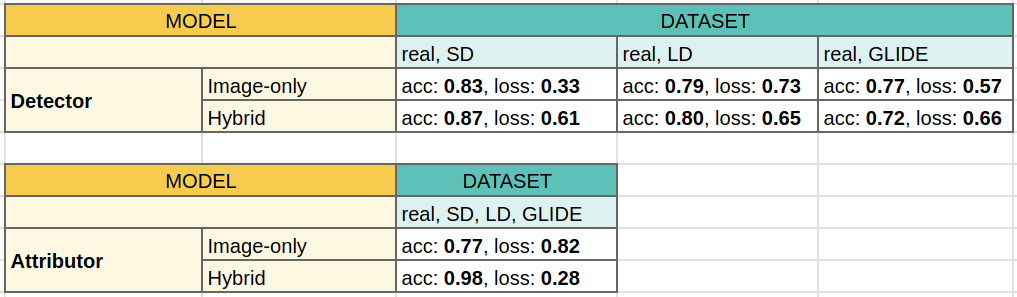

We can conclude that we obtained similar results to the ones described in the original paper, in fact we get in general better results for the Hybrid models, that is something that, as stated in the original study, depends on the high connection that a fake image has with its prompt (higher than the connection between an image and its description), which makes it more easily detectable.<br>

Also, we can notice that the performance of the detectors on SD and LD is better than on GLIDE, this also aligns with what is said in the original paper, and is caused by a similarity in the implementation of the network of SD and LD, and since our model is trained on SD, it is reasonable to expect higher accuracies and lower losses for both SD and LD.<br>

Regarding the actual accuracy and loss values that we obtained, they are significantly lower than the ones reported on the original study, but this is obviously caused but the limited size of the datasets that were used for this project.<br>
In the original study the sizes of the datasets are 40.000 images for the detectors and 80.000 images for the attributors.<br>
In this project, because of limited computational resources, and limited credits for the generation models, the datasets have the sizes 100 images for the detectors and 200 images for the attributors.

Obviously this has a great impact on the ability of the model to learn during training, in particular for the image-only models, that as stated in the original study, achieve huge performance improvements only on datasets with more than 40.000 images.<br>
The hybrid models instead, thanks to the information obtained by the captions, achieve acceptable results even with smaller datasets.

However, despite the reduced performance due to the size of the datasets, the results of this project are in line with the conclusions of the reference study.